# Treinamento e Avaliação de Modelos
## Tech Challenge Fase 4 - Predição de Níveis de Obesidade

> 📘 **Documentação:** Para contexto completo da estratégia de modelagem e justificativas das escolhas técnicas, consulte [00_GUIA_ANALISE.ipynb](00_GUIA_ANALISE.ipynb)

---

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from translations import (
    VARIABLE_NAMES, OBESITY_LABELS, OBESITY_ORDER,
    PRIMARY_COLOR, SECONDARY_COLOR, ACCENT_COLOR,
    translate_variable, get_obesity_label, get_color_palette
)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Bibliotecas importadas")

✅ Bibliotecas importadas


## 1. Carregamento e Preparação dos Dados

In [2]:
df = pd.read_csv('../data/Obesity.csv')
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

print(f"Dataset: {df.shape[0]} linhas, {df.shape[1]} colunas")
print(f"Classes: {df['Obesity'].nunique()} níveis de obesidade")

Dataset: 2111 linhas, 18 colunas
Classes: 7 níveis de obesidade


## 2. Pré-processamento

In [3]:
X = df.drop('Obesity', axis=1)
y = df['Obesity']

print(f"Features: {len(X.columns)}")
print(X.columns.tolist())

Features: 17
['Gender', 'Age', 'Height', 'Weight', 'family_history', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'BMI']


In [4]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categóricas ({len(categorical_cols)}): {categorical_cols}")
print(f"Numéricas ({len(numerical_cols)}): {numerical_cols}")

Categóricas (8): ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
Numéricas (9): ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']


In [5]:
label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print("✅ Encoding concluído")
print(f"Classes: {len(le_target.classes_)}")

✅ Encoding concluído
Classes: 7


In [6]:
scaler = StandardScaler()
X_scaled = X_encoded.copy()
X_scaled[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

print(f"✅ Normalização concluída - Shape: {X_scaled.shape}")

✅ Normalização concluída - Shape: (2111, 17)


## 3. Divisão dos Dados

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Treino: {X_train.shape[0]} | Teste: {X_test.shape[0]} (80/20)")

Treino: 1688 | Teste: 423 (80/20)


## 4. Treinamento de Modelos Baseline

In [8]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss')
}

print(f"Modelos: {len(models)}")

Modelos: 5


In [9]:
results = {}

print("\n" + "="*80)
print("TREINAMENTO DOS MODELOS")
print("="*80)

for name, model in models.items():
    print(f"\n{name}...")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    print(f"  Acurácia: {accuracy*100:.2f}% | CV: {cv_scores.mean()*100:.2f}%")

print("\n" + "="*80)


TREINAMENTO DOS MODELOS

Logistic Regression...
  Acurácia: 91.96% | CV: 90.52%

Decision Tree...
  Acurácia: 97.87% | CV: 96.86%

Random Forest...
  Acurácia: 98.82% | CV: 98.88%

Gradient Boosting...
  Acurácia: 98.11% | CV: 97.63%

XGBoost...
  Acurácia: 98.11% | CV: 97.93%



## 5. Comparação de Modelos

In [10]:
results_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'Acurácia (%)': [results[m]['accuracy']*100 for m in results.keys()],
    'Precisão (%)': [results[m]['precision']*100 for m in results.keys()],
    'Recall (%)': [results[m]['recall']*100 for m in results.keys()],
    'F1-Score (%)': [results[m]['f1_score']*100 for m in results.keys()],
    'CV Score (%)': [results[m]['cv_mean']*100 for m in results.keys()]
}).sort_values('Acurácia (%)', ascending=False).reset_index(drop=True)

print("\nCOMPARAÇÃO DE MODELOS:")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

best_model_name = results_df.iloc[0]['Modelo']
best_accuracy = results_df.iloc[0]['Acurácia (%)']

print(f"\nMelhor: {best_model_name} - {best_accuracy:.2f}%")
print(f"Status: {'✅ Meta atingida (>75%)' if best_accuracy >= 75 else '⚠️ Abaixo da meta'}")


COMPARAÇÃO DE MODELOS:
             Modelo  Acurácia (%)  Precisão (%)  Recall (%)  F1-Score (%)  CV Score (%)
      Random Forest     98.817967     98.860052   98.817967     98.821526     98.875037
  Gradient Boosting     98.108747     98.127002   98.108747     98.106281     97.631029
            XGBoost     98.108747     98.119681   98.108747     98.104403     97.927063
      Decision Tree     97.872340     97.897065   97.872340     97.873436     96.860042
Logistic Regression     91.962175     92.105905   91.962175     91.885502     90.520780

Melhor: Random Forest - 98.82%
Status: ✅ Meta atingida (>75%)


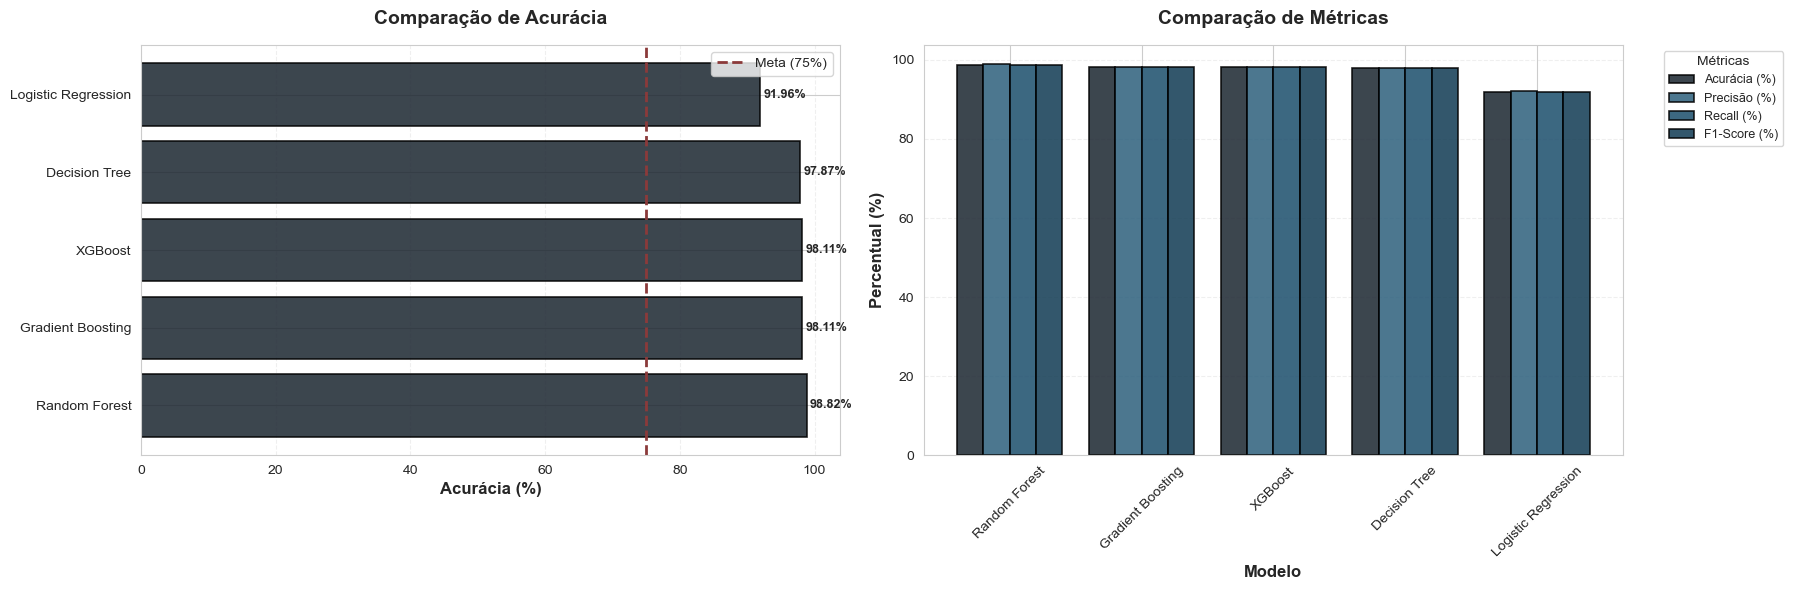

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1: Acurácia com cores baseadas na meta
colors_bars = [PRIMARY_COLOR if acc >= 75 else SECONDARY_COLOR for acc in results_df['Acurácia (%)']]
axes[0].barh(results_df['Modelo'], results_df['Acurácia (%)'], 
            color=colors_bars, edgecolor='black', alpha=0.85, linewidth=1.2)
axes[0].axvline(x=75, color=ACCENT_COLOR, linestyle='--', linewidth=2, label='Meta (75%)')
axes[0].set_xlabel('Acurácia (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Comparação de Acurácia', fontsize=14, fontweight='bold', pad=15)
axes[0].legend(fontsize=10)
axes[0].grid(axis='x', alpha=0.3, linestyle='--')

for idx, val in enumerate(results_df['Acurácia (%)']):
    axes[0].text(val + 0.5, idx, f'{val:.2f}%', va='center', fontweight='bold', fontsize=9)

# Gráfico 2: Métricas com cores padronizadas consistentes
metrics_df = results_df.set_index('Modelo')[['Acurácia (%)', 'Precisão (%)', 'Recall (%)', 'F1-Score (%)']]
# Usar cores consistentes: PRIMARY para Acurácia, variações de SECONDARY para outras
metric_colors = [PRIMARY_COLOR, SECONDARY_COLOR, '#1a4d6b', '#0f3a52']
metrics_df.plot(kind='bar', ax=axes[1], color=metric_colors, 
               edgecolor='black', width=0.8, alpha=0.85, linewidth=1.2)

axes[1].set_title('Comparação de Métricas', fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel('Percentual (%)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Modelo', fontsize=12, fontweight='bold')
axes[1].legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## 6. Análise Detalhada do Melhor Modelo

In [12]:
best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['predictions']

class_names_pt = [get_obesity_label(cls) for cls in le_target.classes_]

print(f"\nRELATÓRIO - {best_model_name.upper()}")
print("="*80)
print(classification_report(y_test, y_pred_best, target_names=class_names_pt, digits=4))
print("="*80)


RELATÓRIO - RANDOM FOREST
                   precision    recall  f1-score   support

Peso Insuficiente     1.0000    0.9815    0.9907        54
      Peso Normal     0.9508    1.0000    0.9748        58
      Obesidade I     0.9859    1.0000    0.9929        70
     Obesidade II     0.9836    1.0000    0.9917        60
    Obesidade III     1.0000    0.9846    0.9922        65
      Sobrepeso I     1.0000    0.9655    0.9825        58
     Sobrepeso II     1.0000    0.9828    0.9913        58

         accuracy                         0.9882       423
        macro avg     0.9886    0.9878    0.9880       423
     weighted avg     0.9886    0.9882    0.9882       423



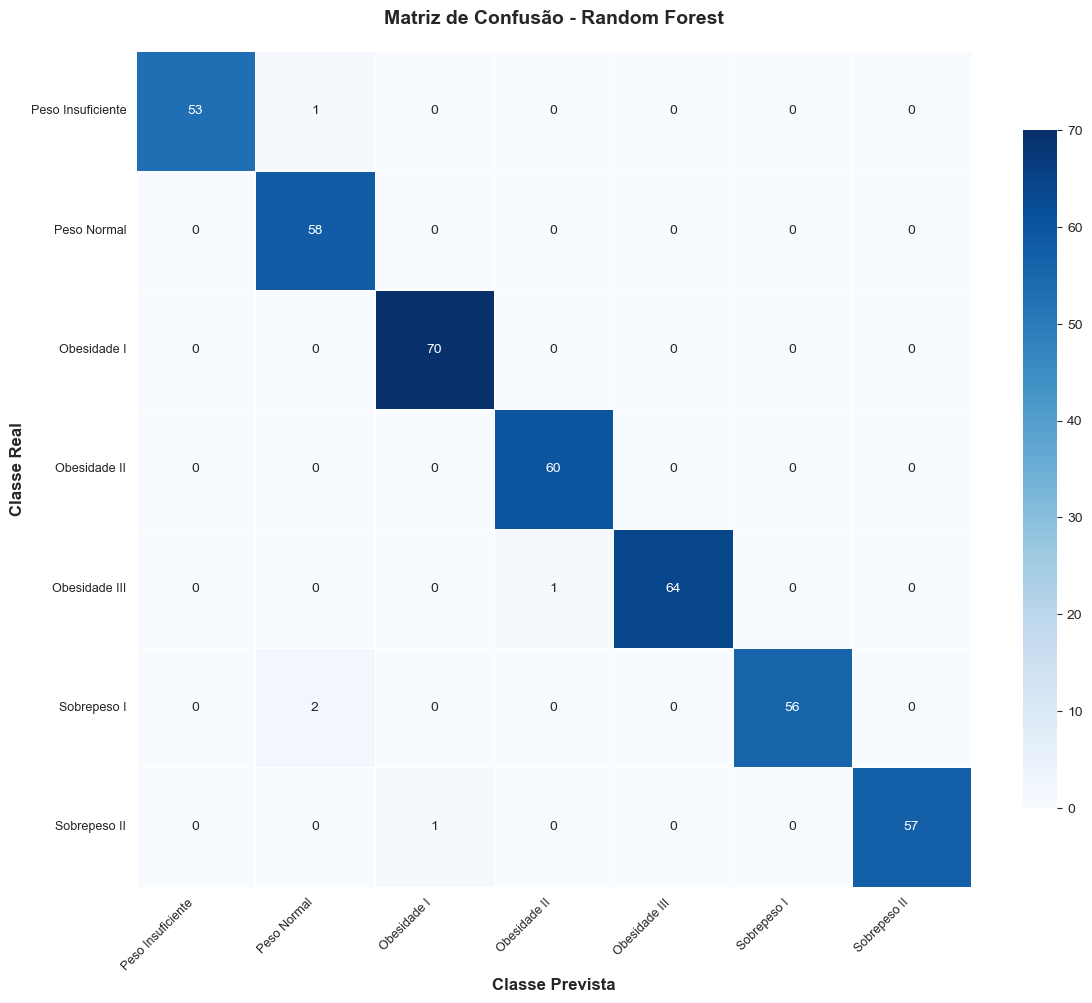


Acurácia por Classe:
  Peso Insuficiente        :  98.15%
  Peso Normal              : 100.00%
  Obesidade I              : 100.00%
  Obesidade II             : 100.00%
  Obesidade III            :  98.46%
  Sobrepeso I              :  96.55%
  Sobrepeso II             :  98.28%


In [13]:
cm = confusion_matrix(y_test, y_pred_best)
class_names_pt = [get_obesity_label(cls) for cls in le_target.classes_]

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names_pt,
            yticklabels=class_names_pt,
            square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            annot_kws={"fontsize": 10})
plt.title(f'Matriz de Confusão - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Classe Real', fontsize=12, fontweight='bold')
plt.xlabel('Classe Prevista', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nAcurácia por Classe:")
print("="*70)
for idx, acc in enumerate(class_accuracy):
    print(f"  {class_names_pt[idx]:25s}: {acc*100:6.2f}%")
print("="*70)

## 7. Feature Importance (se aplicável)


IMPORTÂNCIA DAS FEATURES:
                  Feature_PT  Importance
                         IMC    0.419207
                        Peso    0.214071
         Consumo de Vegetais    0.060294
                       Idade    0.052244
                      Altura    0.051284
                      Gênero    0.046055
Refeições Principais por Dia    0.027062
              Tempo em Telas    0.021157
             Consumo de Água    0.020044
     Consumo Entre Refeições    0.019563


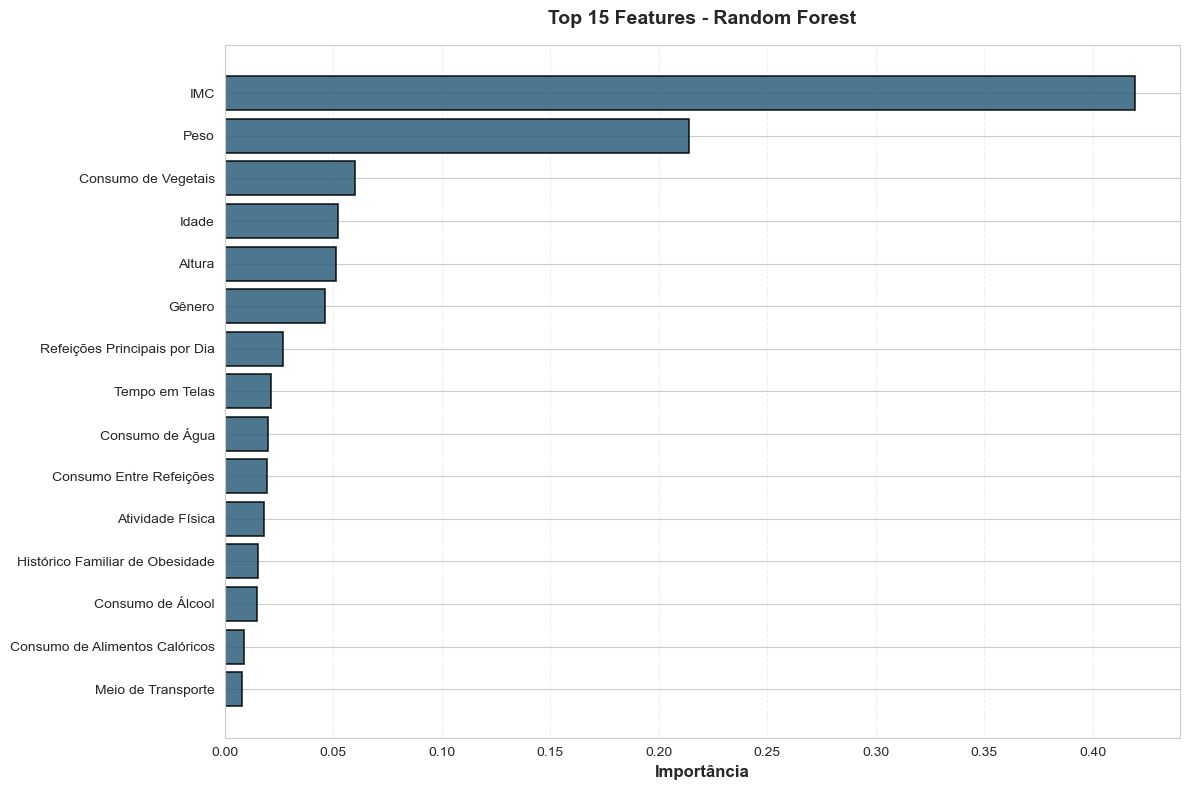

In [14]:
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_scaled.columns,
        'Feature_PT': [translate_variable(col) for col in X_scaled.columns],
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nIMPORTÂNCIA DAS FEATURES:")
    print("="*80)
    print(feature_importance[['Feature_PT', 'Importance']].head(10).to_string(index=False))
    print("="*80)
    
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(top_features['Feature_PT'], top_features['Importance'], 
           color=SECONDARY_COLOR, edgecolor='black', alpha=0.85, linewidth=1.2)
    plt.xlabel('Importância', fontsize=12, fontweight='bold')
    plt.title(f'Top 15 Features - {best_model_name}', fontsize=14, fontweight='bold', pad=15)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print(f"\n{best_model_name} não possui feature_importances_")

## 8. Otimização do Melhor Modelo (GridSearch)

In [15]:
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0]
    }
}

if best_model_name in param_grids:
    print(f"\nOtimizando {best_model_name}...")
    print("="*80)
    
    grid_search = GridSearchCV(
        best_model,
        param_grids[best_model_name],
        cv=5,
        scoring='accuracy',
        n_jobs=1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("\n✅ Otimização concluída")
    print(f"\nMelhores Parâmetros:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    
    optimized_model = grid_search.best_estimator_
    y_pred_optimized = optimized_model.predict(X_test)
    optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
    
    print(f"\nComparação:")
    print(f"  Original: {best_accuracy:.2f}%")
    print(f"  Otimizado: {optimized_accuracy*100:.2f}%")
    print(f"  Melhoria: {(optimized_accuracy*100 - best_accuracy):.2f}pp")
    
    if optimized_accuracy > results[best_model_name]['accuracy']:
        best_model = optimized_model
        print("\n✅ Modelo otimizado selecionado")
    else:
        print("\n⚠️ Modelo original mantido")
else:
    print(f"\nGrid Search não configurado para {best_model_name}")


Otimizando Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Otimização concluída

Melhores Parâmetros:
  max_depth: 20
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

Comparação:
  Original: 98.82%
  Otimizado: 99.05%
  Melhoria: 0.24pp

✅ Modelo otimizado selecionado


## 9. Feature Importance do Modelo Otimizado


IMPORTÂNCIA DAS FEATURES (MODELO OTIMIZADO):
                     Feature_PT  Importance
                            IMC    0.409692
                           Peso    0.210544
            Consumo de Vegetais    0.062131
                          Idade    0.051644
                         Altura    0.051481
                         Gênero    0.045901
   Refeições Principais por Dia    0.027189
                 Tempo em Telas    0.022118
        Consumo Entre Refeições    0.021949
                Consumo de Água    0.020923
               Atividade Física    0.020242
Histórico Familiar de Obesidade    0.017441
              Consumo de Álcool    0.016322
 Consumo de Alimentos Calóricos    0.009766
             Meio de Transporte    0.008646
              Monitora Calorias    0.003075
                        Fumante    0.000936


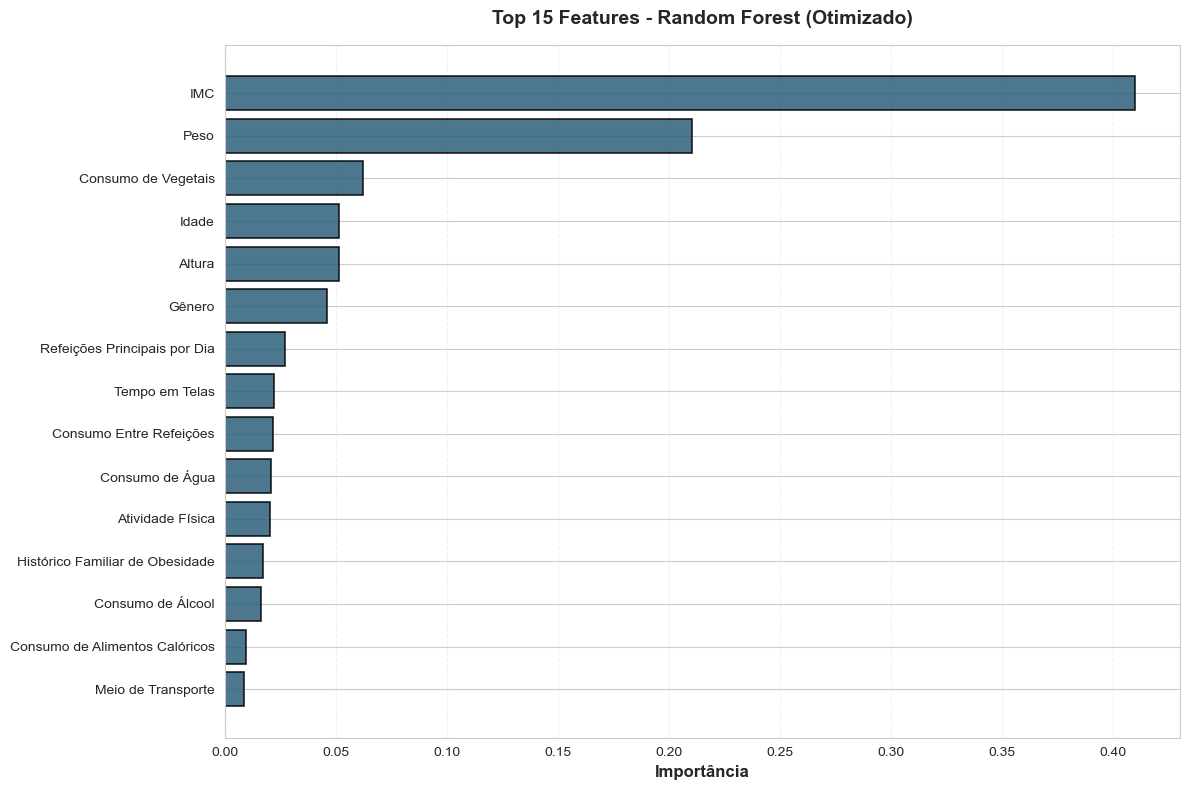


TOP 5 FEATURES:
  IMC: 40.97%
  Peso: 21.05%
  Consumo de Vegetais: 6.21%
  Idade: 5.16%
  Altura: 5.15%

Importância combinada Height/Weight/BMI: 67.17%
⚠️ Features antropométricas dominam a predição (>50%)


In [16]:
if hasattr(best_model, 'feature_importances_'):
    feature_importance_optimized = pd.DataFrame({
        'Feature': X_scaled.columns,
        'Feature_PT': [translate_variable(col) for col in X_scaled.columns],
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nIMPORTÂNCIA DAS FEATURES (MODELO OTIMIZADO):")
    print("="*80)
    print(feature_importance_optimized[['Feature_PT', 'Importance']].to_string(index=False))
    print("="*80)
    
    plt.figure(figsize=(12, 8))
    top_features_opt = feature_importance_optimized.head(15)
    plt.barh(top_features_opt['Feature_PT'], top_features_opt['Importance'], 
             color=SECONDARY_COLOR, edgecolor='black', alpha=0.85, linewidth=1.2)
    plt.xlabel('Importância', fontsize=12, fontweight='bold')
    plt.title(f'Top 15 Features - {best_model_name} (Otimizado)', 
              fontsize=14, fontweight='bold', pad=15)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    print("\nTOP 5 FEATURES:")
    print("="*80)
    for i, row in feature_importance_optimized.head(5).iterrows():
        print(f"  {row['Feature_PT']}: {row['Importance']*100:.2f}%")
    
    anthro_features = ['Height', 'Weight', 'BMI']
    anthro_importance = feature_importance_optimized[
        feature_importance_optimized['Feature'].isin(anthro_features)
    ]['Importance'].sum()
    
    print(f"\nImportância combinada Height/Weight/BMI: {anthro_importance*100:.2f}%")
    if anthro_importance > 0.5:
        print("⚠️ Features antropométricas dominam a predição (>50%)")
    print("="*80)
else:
    print(f"\n{best_model_name} não possui feature_importances_")

## 10. Teste Alternativo: Modelo SEM Features Antropométricas

- Demonstra **verdadeiro poder preditivo** dos hábitos de vida

**Insight Crítico**: Height, Weight e BMI são **matematicamente redundantes** e criam circularidade:- Identifica **fatores modificáveis** para intervenção preventiva

- BMI = Weight / Height²- Útil para **screening remoto** (questionário online sem balança/fita métrica)

- Classes de obesidade SÃO DEFINIDAS por faixas de IMC (WHO)- Modelo mais **generalizável** (não depende de medições físicas diretas)

**Por que isso é importante?**

**Objetivo**: Testar se o modelo consegue prever obesidade usando APENAS:

- ✅ **Fatores Comportamentais**: FAF, FAVC, FCVC, NCP, CAEC, SMOKE, CH2O, SCC, TUE, CALC, MTRANS- ✅ **Demografia**: Age, Gender
- ✅ **Fatores Genéticos**: family_history

In [17]:
print("\n" + "="*80)
print("MODELO COMPORTAMENTAL (sem Height/Weight/BMI)")
print("="*80)

anthropometric_features = ['Height', 'Weight', 'BMI']
X_behavioral = df.drop(['Obesity'] + anthropometric_features, axis=1)

print(f"\nFeatures: {len(X.columns)} → {len(X_behavioral.columns)}")
print(f"Removidas: {anthropometric_features}")

categorical_cols_beh = X_behavioral.select_dtypes(include=['object']).columns.tolist()
numerical_cols_beh = X_behavioral.select_dtypes(include=[np.number]).columns.tolist()

label_encoders_beh = {}
X_behavioral_encoded = X_behavioral.copy()

for col in categorical_cols_beh:
    le = LabelEncoder()
    X_behavioral_encoded[col] = le.fit_transform(X_behavioral[col])
    label_encoders_beh[col] = le

scaler_beh = StandardScaler()
X_behavioral_scaled = X_behavioral_encoded.copy()
X_behavioral_scaled[numerical_cols_beh] = scaler_beh.fit_transform(X_behavioral_encoded[numerical_cols_beh])

X_train_beh, X_test_beh, y_train_beh, y_test_beh = train_test_split(
    X_behavioral_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Treino: {X_train_beh.shape[0]} | Teste: {X_test_beh.shape[0]}")


MODELO COMPORTAMENTAL (sem Height/Weight/BMI)

Features: 17 → 14
Removidas: ['Height', 'Weight', 'BMI']
Treino: 1688 | Teste: 423


In [18]:
results_behavioral = {}

for name, model_class in [('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
                           ('XGBoost', XGBClassifier(random_state=42, eval_metric='mlogloss')),
                           ('Gradient Boosting', GradientBoostingClassifier(random_state=42))]:
    
    print(f"\n{name}...")
    
    model_class.fit(X_train_beh, y_train_beh)
    y_pred_beh = model_class.predict(X_test_beh)
    
    accuracy = accuracy_score(y_test_beh, y_pred_beh)
    precision = precision_score(y_test_beh, y_pred_beh, average='weighted')
    recall = recall_score(y_test_beh, y_pred_beh, average='weighted')
    f1 = f1_score(y_test_beh, y_pred_beh, average='weighted')
    cv_scores = cross_val_score(model_class, X_train_beh, y_train_beh, cv=5)
    
    results_behavioral[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"  Acurácia: {accuracy*100:.2f}%")

print("\n" + "="*80)


Random Forest...
  Acurácia: 87.47%

XGBoost...
  Acurácia: 85.82%

Gradient Boosting...
  Acurácia: 82.27%



## 11. Salvar Modelo e Artefatos

In [19]:
model_path = '../models/best_model.pkl'
joblib.dump(best_model, model_path)
print(f"✅ Modelo: {model_path}")

encoders_path = '../models/label_encoders.pkl'
joblib.dump(label_encoders, encoders_path)
print(f"✅ Encoders: {encoders_path}")

target_encoder_path = '../models/target_encoder.pkl'
joblib.dump(le_target, target_encoder_path)
print(f"✅ Target Encoder: {target_encoder_path}")

scaler_path = '../models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler: {scaler_path}")

features_path = '../models/feature_names.pkl'
joblib.dump(X_scaled.columns.tolist(), features_path)
print(f"✅ Features: {features_path}")

metrics_path = '../models/model_metrics.pkl'
model_metrics = {
    'model_name': best_model_name,
    'accuracy': optimized_accuracy if 'optimized_accuracy' in locals() else best_accuracy/100,
    'results_df': results_df
}
joblib.dump(model_metrics, metrics_path)
print(f"✅ Métricas: {metrics_path}")

print("\n" + "="*80)
print("ARTEFATOS SALVOS COM SUCESSO")
print("="*80)

✅ Modelo: ../models/best_model.pkl
✅ Encoders: ../models/label_encoders.pkl
✅ Target Encoder: ../models/target_encoder.pkl
✅ Scaler: ../models/scaler.pkl
✅ Features: ../models/feature_names.pkl
✅ Métricas: ../models/model_metrics.pkl

ARTEFATOS SALVOS COM SUCESSO


## 12. Resumo Final

In [21]:
print("\n" + "="*80)
print("RESUMO FINAL")
print("="*80)

print(f"\nMelhor Modelo: {best_model_name}")
final_accuracy = optimized_accuracy*100 if 'optimized_accuracy' in locals() else best_accuracy
print(f"Acurácia: {final_accuracy:.2f}%")
print(f"Status: {'✅ Meta atingida (>75%)' if final_accuracy >= 75 else '⚠️ Abaixo da meta'}")

if 'results_behavioral' in locals():
    print("\n" + "-"*80)
    print("Comparação: Modelo Completo vs Comportamental")
    print("-"*80)
    for name in ['Random Forest', 'XGBoost', 'Gradient Boosting']:
        if name in results and name in results_behavioral:
            full = results[name]['accuracy'] * 100
            behav = results_behavioral[name]['accuracy'] * 100
            print(f"  {name}: {full:.2f}% vs {behav:.2f}%")

print("\n" + "-"*80)
print("Artefatos Salvos")
print("-"*80)
print(f"  Modelo: {model_path}")
print(f"  Encoders: {encoders_path}")
print(f"  Scaler: {scaler_path}")

print("\n" + "="*80)


RESUMO FINAL

Melhor Modelo: Random Forest
Acurácia: 99.05%
Status: ✅ Meta atingida (>75%)

--------------------------------------------------------------------------------
Comparação: Modelo Completo vs Comportamental
--------------------------------------------------------------------------------
  Random Forest: 98.82% vs 87.47%
  XGBoost: 98.11% vs 85.82%
  Gradient Boosting: 98.11% vs 82.27%

--------------------------------------------------------------------------------
Artefatos Salvos
--------------------------------------------------------------------------------
  Modelo: ../models/best_model.pkl
  Encoders: ../models/label_encoders.pkl
  Scaler: ../models/scaler.pkl

